In [1]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from skimage.feature import graycoprops
from skimage.feature.texture import graycomatrix

In [2]:
data_dir = 'data/Training'
classes = os.listdir(data_dir)
print(f'Liczba klas: {len(classes)}')
print('Klasy:', classes)

Liczba klas: 50
Klasy: ['Apple Red 2', 'Apricot 1', 'Avocado 1', 'Banana 1', 'Blueberry 1', 'Cactus fruit 1', 'Cantaloupe 1', 'Carrot 1', 'Cherry 1', 'Clementine 1', 'Cocos 1', 'Corn 1', 'Cucumber 1', 'Dates 1', 'Eggplant 1', 'Fig 1', 'Grape White 1', 'Kiwi 1', 'Lemon 1', 'Lemon Meyer 1', 'Limes 1', 'Lychee 1', 'Mandarine 1', 'Mango 1', 'Mango Red 1', 'Mangostan 1', 'Maracuja 1', 'Mulberry 1', 'Nectarine 1', 'Onion Red 1', 'Onion White 1', 'Orange 1', 'Papaya 1', 'Passion Fruit 1', 'Peach 1', 'Pear 1', 'Pepper Red 1', 'Pineapple 1', 'Pineapple Mini 1', 'Pitahaya Red 1', 'Plum 1', 'Pomegranate 1', 'Pomelo Sweetie 1', 'Raspberry 1', 'Redcurrant 1', 'Strawberry 1', 'Tangelo 1', 'Tomato 1', 'Watermelon 1', 'Zucchini 1']


In [ ]:
def extract_features(image):
    image = cv2.resize(image, (100, 100))
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    hist_features = hist.flatten()
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256,
                        symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    
    texture_features = [contrast, dissimilarity, homogeneity, energy, correlation, ASM]
    
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)

    edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])

    features = np.hstack([hist_features, texture_features, edge_density])
    
    return features

In [4]:
X_train = []
y_train = []

for label in classes:
    path = os.path.join(data_dir, label)
    for img_name in os.listdir(path):
        print(f'processing: {img_name}')
        img_path = os.path.join(path, img_name)
        image = cv2.imread(img_path)
        features = extract_features(image)
        X_train.append(features)
        y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

processing: 0_100.jpg
processing: 100_100.jpg
processing: 101_100.jpg
processing: 102_100.jpg
processing: 103_100.jpg
processing: 104_100.jpg
processing: 105_100.jpg
processing: 106_100.jpg
processing: 107_100.jpg
processing: 108_100.jpg
processing: 109_100.jpg
processing: 10_100.jpg
processing: 110_100.jpg
processing: 111_100.jpg
processing: 112_100.jpg
processing: 113_100.jpg
processing: 114_100.jpg
processing: 115_100.jpg
processing: 116_100.jpg
processing: 117_100.jpg
processing: 118_100.jpg
processing: 119_100.jpg
processing: 11_100.jpg
processing: 120_100.jpg
processing: 121_100.jpg
processing: 122_100.jpg
processing: 123_100.jpg
processing: 124_100.jpg
processing: 125_100.jpg
processing: 126_100.jpg
processing: 127_100.jpg
processing: 128_100.jpg
processing: 129_100.jpg
processing: 12_100.jpg
processing: 130_100.jpg
processing: 131_100.jpg
processing: 132_100.jpg
processing: 133_100.jpg
processing: 134_100.jpg
processing: 135_100.jpg
processing: 136_100.jpg
processing: 137_100.j

In [5]:
data_dir_test = 'data/Test'
X_test = []
y_test = []

for label in classes:
    path = os.path.join(data_dir_test, label)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        image = cv2.imread(img_path)
        features = extract_features(image)
        X_test.append(features)
        y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [6]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [7]:
y_pred_knn = knn.predict(X_test)
print('Accuracy K-NN:', accuracy_score(y_test, y_pred_knn))
print('Classification Report K-NN:')
print(classification_report(y_test, y_pred_knn))

Accuracy K-NN: 0.585553731531759
Classification Report K-NN:
                  precision    recall  f1-score   support

     Apple Red 2       0.45      0.82      0.59       164
       Apricot 1       0.83      0.67      0.74       164
       Avocado 1       0.43      0.63      0.51       143
        Banana 1       0.78      0.64      0.70       166
     Blueberry 1       0.55      0.58      0.57       154
  Cactus fruit 1       0.42      0.51      0.46       166
    Cantaloupe 1       0.98      1.00      0.99       164
        Carrot 1       1.00      0.98      0.99        50
        Cherry 1       0.44      0.82      0.57       164
    Clementine 1       0.78      0.63      0.70       166
         Cocos 1       0.88      0.35      0.50       166
          Corn 1       0.83      0.53      0.64       150
      Cucumber 1       0.98      0.96      0.97        50
         Dates 1       0.63      0.75      0.68       166
      Eggplant 1       0.78      0.33      0.46       156
          

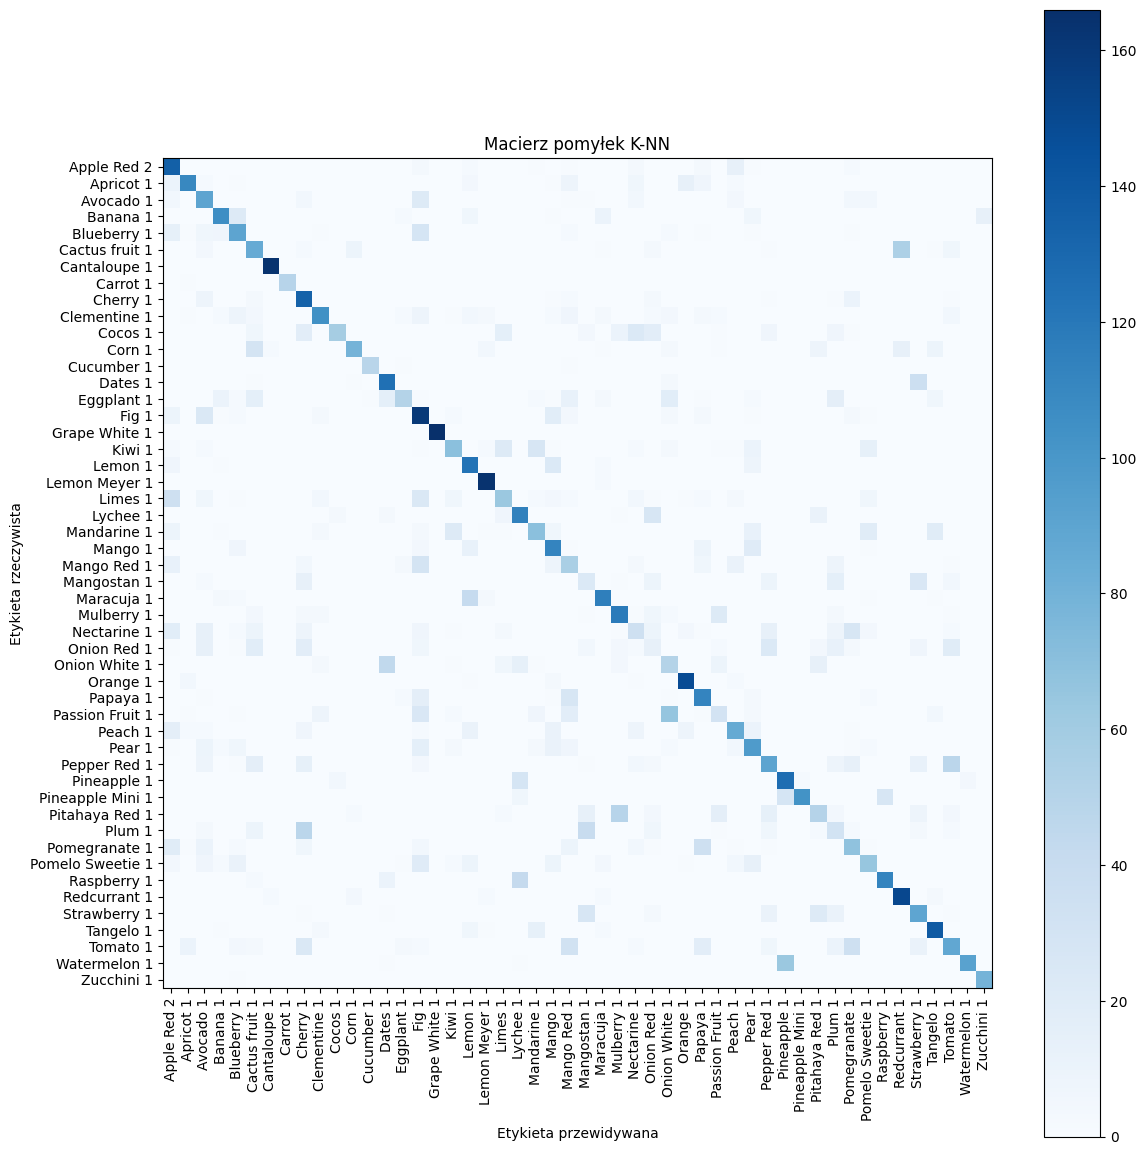

In [8]:
cm = confusion_matrix(y_test, y_pred_knn, labels=classes)
plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Macierz pomyłek K-NN')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('Etykieta rzeczywista')
plt.xlabel('Etykieta przewidywana')
plt.show()

# Przykłady

# Histogram HSV

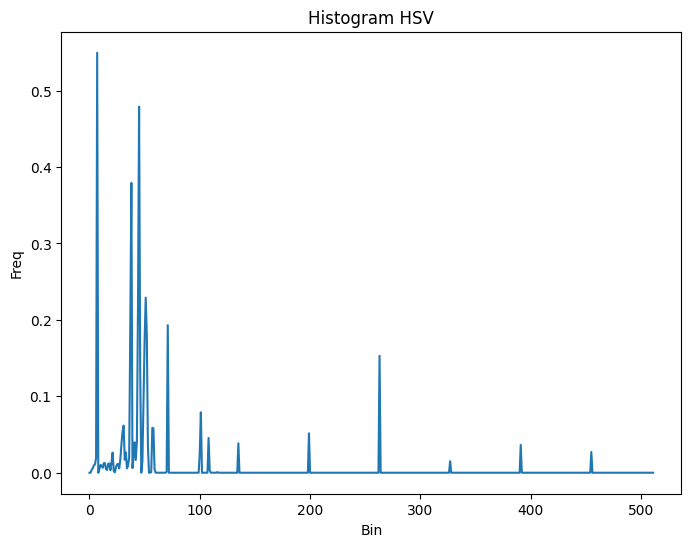

In [13]:
def plot_histogram(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (100, 100))
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    
    plt.figure(figsize=(8, 6))
    plt.title("Histogram HSV")
    plt.xlabel("Bin")
    plt.ylabel("Freq")
    plt.plot(hist.flatten())
    plt.show()

plot_histogram('data/Training/Apple Red 2/0_100.jpg')

# GLCM

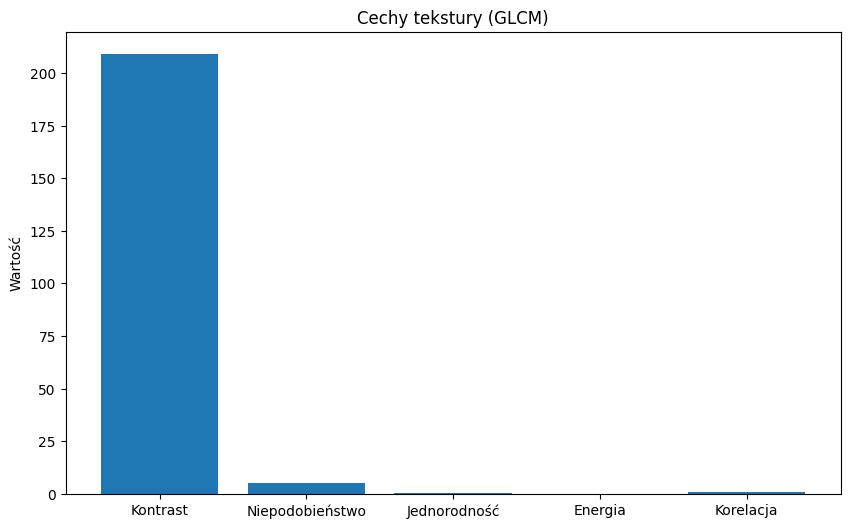

In [14]:
def plot_glcm_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256,
                        symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    features = {
        'Kontrast': contrast,
        'Niepodobieństwo': dissimilarity,
        'Jednorodność': homogeneity,
        'Energia': energy,
        'Korelacja': correlation
    }
    
    plt.figure(figsize=(10, 6))
    plt.bar(features.keys(), features.values())
    plt.title("Cechy tekstury (GLCM)")
    plt.ylabel("Wartość")
    plt.show()

plot_glcm_features('data/Training/Apple Red 2/0_100.jpg')

# Canny

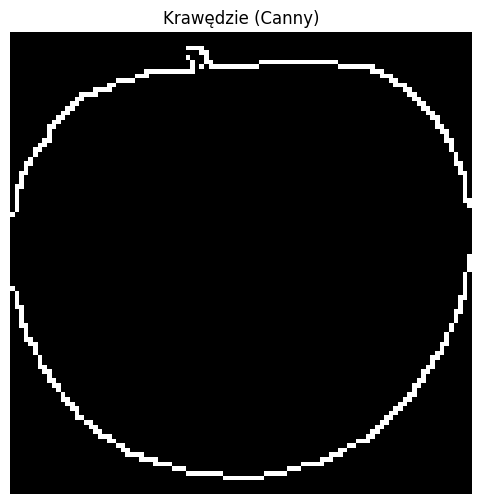

In [15]:
def plot_edges(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    
    plt.figure(figsize=(6, 6))
    plt.title("Krawędzie (Canny)")
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()

plot_edges('data/Training/Apple Red 2/0_100.jpg')